------------------------------------------------------------------------

# Summary

------------------------------------------------------------------------

> Expand to see summary and details

## Overview and Explanation

1.  This notebook reuses a lot of the [original transfer learning
    notebook](https://colab.research.google.com/drive/187Z04CNQBVV3jmCdA2sSbMTs9BB40qh_#scrollTo=QgZD08Q-YXXH)
    -   Here the focus is on building the new custom model using the
        CovidNet-CT database.
2.  The [`Setup Kaggle`](#scrollTo=wMQLloEgzPol) section:
    -   is not longer needed for notebook running in kaggle. Remained
        here for references only
    -   is where the dataset is being acquired.
    -   Explanation of various phases in the [CovidNet-CT ML
        code](https://github.com/haydengunraj/COVIDNet-CT/blob/02009821b9d063d01994cb70e61b8def0af275ab/run_covidnet_ct.py#L415):
        -   train phase is train phase
        -   test phase is validation phase
        -   infer phase is test phase
3.  The [`Data Preprocessing`](#scrollTo=JjsNA--kG9CV) section:
    -   refers to the way [CovidNet-CT preprocess its
        data](https://github.com/haydengunraj/COVIDNet-CT/blob/d1c6be5202a78d5f8802e40ff6b5b9d57189c797/dataset.py#L72)
    -   CovidNet-CT uses TensorFlow while this notebook adapts the code
        to use PyTorch
    -   Two highlights
        -   input shape is (512, 512, 3) instead of the (224, 224, 3)
            used by the imagenet model
        -   the image is cropped to the bounding box provided with the
            dataset before resize to 512x512
4.  The [`Training & Validation`](#scrollTo=YqGCBwYdasI_) section:
    -   refers to [how CovidNet-CT
        trains](https://github.com/haydengunraj/COVIDNet-CT/blob/02009821b9d063d01994cb70e61b8def0af275ab/run_covidnet_ct.py#L174)
    -   This part is almost identical to the original transfer learning
        model notebook.

------------------------------------------------------------------------

# Import and Deterministic Setup

------------------------------------------------------------------------

All modules will be imported here including modules used in the
[Playground](#playground) section

In [1]:
from __future__ import print_function, division
import os
%env CUDA_LAUNCH_BLOCKING=1
import random
import numpy as np
import torch

from os import path
import math
import sys

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from PIL import Image
from sklearn.model_selection import train_test_split #, StratifiedShuffleSplit

import torchvision
from torchvision import models, transforms #, datasets
import matplotlib.pyplot as plt

from torch import optim
from torch.nn import Module, Sequential, LeakyReLU, Conv2d, BatchNorm2d, AvgPool2d, MaxPool2d, AdaptiveAvgPool2d, Linear, CrossEntropyLoss
from torch.optim import lr_scheduler
import time
import torch.nn.functional as F

import gc
import pandas as pd
import enum
from enum import Enum

# ensure reproducibility across different executions
# https://pytorch.org/docs/stable/notes/randomness.html
# https://www.kaggle.com/mlwhiz/third-place-model-for-toxic-comments-in-pytorch
# https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html
SEED = 18
def seed_everything(seed=18):
    random.seed(seed)
    %env PYTHONHASHSEED=$seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
#torch.set_deterministic(True)
torch.use_deterministic_algorithms(True)
%env CUBLAS_WORKSPACE_CONFIG=:4096:8
%env PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512
        
# https://www.kaggle.com/code/manabendrarout/vision-transformer-vit-pytorch-on-tpus-train/notebook
def is_tpu_avail():
    TPU_DETECTED = False
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        TPU_DETECTED = True
    except:
        pass

    return TPU_DETECTED


def is_gpu_avail():
    GPU_DETECTED = False
    try:
        GPU_DETECTED = torch.cuda.is_available()
    except:
        pass

    return GPU_DETECTED

env: CUDA_LAUNCH_BLOCKING=1
env: CUBLAS_WORKSPACE_CONFIG=:4096:8
env: PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512


------------------------------------------------------------------------

# Data Preprocessing

------------------------------------------------------------------------

-   [how torch dataset is loaded](https://github.com/pytorch/vision/blob/main/torchvision/datasets/folder.py#L45)
-   [example custom model and custom dataset](https://github.com/ArnaudMallet/Plant_Patho/blob/master/Plant_Patho_4.ipynb)
    -   [pytorch thread](https://discuss.pytorch.org/t/how-to-load-data-from-a-csv/58315/10) that mentioned this example
-   [A well explained custom dataset](https://github.com/utkuozbulak/pytorch-custom-dataset-examples)

## Custom Dataset class to load CovidNet data

- Various references used: 
  - https://colab.research.google.com/drive/187Z04CNQBVV3jmCdA2sSbMTs9BB40qh\_#scrollTo=H9doKmx1TXK1 
  - https://drive.google.com/drive/folders/13PnDpSYUaVaKHjXjUK6bwWvJddDfbRad 
  - https://github.com/haydengunraj/COVIDNet-CT/blob/d1c6be5202a78d5f8802e40ff6b5b9d57189c797/dataset.py#L72 
  - https://github.com/haydengunraj/COVIDNet-CT/blob/master/docs/dataset.md 
  - https://www.kaggle.com/datasets/hgunraj/covidxct?select=metadata.csv 
  - https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets/50544887#50544887 
  - https://github.com/pytorch/vision/blob/main/torchvision/datasets/folder.py 
  - https://github.com/pytorch/vision/blob/d4a03fc02d0566ec97341046de58160370a35bd2/torchvision/datasets/vision.py#L10

In [2]:
class CovidNetDataset(Dataset):
    def __init__(self, img_dir, split_files, limit_size = 0, transform = None):
        super().__init__()
        self.img_dir = img_dir
        self.split_files = split_files
        self.size = 0
        self.limit_size = limit_size

        self.imgs, self.targets, self.bboxes = self.get_all_split_file_data()
        self.classes = self.get_classes()
        self.stradify_removal_based_on_limit()
        # self.imgs = [entry.name for entry in os.scandir(img_dir) if entry.is_file()]
        self.transform = transform

    def __len__(self):
        return self.size # len(self.imgs)

    def __getitem__(self, index):
        # filename = self.df[index, "FILENAME"]
        # label = self.class_to_idx [self.df[index, "LABEL"]]
        # image = Image.open(os.path.join(self.img_dir, filename))

        label = self.targets[index]
        with open(self.imgs[index], "rb") as f:
            image = Image.open(f)
            image = image.crop(self.bboxes[index])
            image = image.copy()

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    
    # from https://github.com/pytorch/vision/blob/main/torchvision/datasets/folder.py#L36
    def find_classes(self):
        class_names = ['Normal', 'Pneumonia', 'COVID-19']
        class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}
        return class_names, class_to_idx


    def get_classes(self, csv_path=None):
        """Returns class name array (that corresponds to targets array) and class_to_idx.
        See :class:`CovidNetDataset` for details.
        """

        # hard code classes as the order are not alphabetic
        all_class = ['Normal', 'Pneumonia', 'COVID-19']
        classes = []

        # class_to_idx = {cls_name: i for i, cls_name in enumerate(all_class)}
        idx_to_class = {i : cls_name for i, cls_name in enumerate(all_class)}

        for idx in self.targets:
            classes.extend(idx_to_class[idx])

        return classes


    def get_all_split_file_data(self):
        files, classes, bboxes = [], [], []
        for split_file in self.split_files:
            f, cls, bb = self.get_data_from_split_file(split_file)
            files.extend(f)
            classes.extend(cls)
            bboxes.extend(bb)
        return files, classes, bboxes


    # from https://github.com/haydengunraj/COVIDNet-CT/blob/d1c6be5202a78d5f8802e40ff6b5b9d57189c797/dataset.py#L108
    def get_data_from_split_file(self, split_file):
        """Gets image filenames, classes and bboxes"""
        files, classes, bboxes = [], [], []
        with open(split_file, 'r') as f:
            for line in f.readlines():
                fname, cls, xmin, ymin, xmax, ymax = line.strip('\n').split()
                files.append(path.join(self.img_dir, fname))
                classes.append(int(cls))
                bboxes.append([int(xmin), int(ymin), int(xmax), int(ymax)])
                self.size += 1
        return files, classes, bboxes
    

    '''Try to do stratified removal based on limit count if it is specified'''
    def stradify_removal_based_on_limit(self):
        _, class_to_idx = self.find_classes()
        MIN_SIZE = len(class_to_idx) * 10 # allow for some buffer to work with
        if self.limit_size <= 0 or self.limit_size <= MIN_SIZE or self.limit_size >= self.size:
            return
        
        total_remove_count = self.size - self.limit_size
        occurrence = {idx: self.targets.count(idx) for _, idx in class_to_idx.items()}
        target_remove_count = {idx: 0 for _, idx in class_to_idx.items()}
        for idx, count in occurrence.items():
            target_remove_count[idx] = math.floor(total_remove_count * count / self.size)
        
        print(f"occurrence= {occurrence}")
        print(f"target_remove_count= {target_remove_count}")
        
        for i in reversed(range(len(self.targets))):
            idx = self.targets[i]
            if target_remove_count[idx] > 0:
                del self.targets[i]
                del self.imgs[i]
                del self.bboxes[i]
                target_remove_count[idx] -= 1
                self.size -= 1
                
                
                
# https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
class CovidNetDatasetWithPath(CovidNetDataset):
    def __init__(self, img_dir, split_files, limit_size = 0, transform = None):
        super().__init__(img_dir, split_files, limit_size, transform)


    """Custom dataset that includes image file paths. Originally extends torchvision.datasets.ImageFolder
    Now adapted to extend CovidNetDataset
    """  
    def __getitem__(self, index):
        original_tuple = super().__getitem__(index) 
        path = self.imgs[index]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

## Spliting dataset into train, val, test

-   [SO QA on spliting using sklearn](https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn)
    -   [Train test split example](https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test)
    -   [train test split example with indices](https://stackoverflow.com/questions/31521170/scikit-learn-train-test-split-with-indices)
-   [Pytorch stratified split example](https://discuss.pytorch.org/t/how-to-do-a-stratified-split/62290)
-   [sklearn StratifiedShuffleSplit doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html)
-   [StratifiedShuffleSplit example](https://stackoverflow.com/questions/29438265/stratified-train-test-split-in-scikit-learn)
-   [another StratifiedShuffleSplit example](https://stackoverflow.com/questions/40829137/stratified-train-validation-test-split-in-scikit-learn)

In [3]:
# Specify all the filepath of the dataset
CURR_DIR = "/kaggle/working"
DATA_DIR = "/kaggle/input/covidxct"
dirs = [entry.name for entry in os.scandir(DATA_DIR) if entry.is_dir()]
assert len(dirs) == 1 # expects to only have 1 folder that contains all the images

DATASET_DIR = path.join(DATA_DIR, dirs[0])
METADATA_CSV = path.join(DATA_DIR, "metadata.csv")

DATASET_NAME = "COVIDx_CT-3A"
TRAIN_SPLIT_FILE = path.join(DATA_DIR, f"train_{DATASET_NAME}.txt")
VAL_SPLIT_FILE = path.join(DATA_DIR, f"val_{DATASET_NAME}.txt")
TEST_SPLIT_FILE = path.join(DATA_DIR, f"test_{DATASET_NAME}.txt")
SPLIT_FILES = [TRAIN_SPLIT_FILE, VAL_SPLIT_FILE, TEST_SPLIT_FILE]

MAX_COUNT = 10000
full_dataset = CovidNetDataset(DATASET_DIR, SPLIT_FILES, MAX_COUNT)
full_data_len = len(full_dataset)
print(f"Length of full dataset: {full_data_len}")

# # Defines ratios, w.r.t. whole dataset.
ratio_train = 0.8
ratio_val = 0.1
ratio_test = 0.1
dummy_X = np.zeros(full_data_len)
indexes = np.arange(full_data_len)

# Produces test split. Uses train_test_split instead of StratifiedShuffleSplit to get x_remaining & y_remaining
# to be used in the next step. 
# Note that an additional indexes array is provided
x_remaining, _, y_remaining, _, temp_train_index, test_index = train_test_split(
    dummy_X, full_dataset.targets, indexes, test_size=ratio_test, stratify=full_dataset.targets, random_state=SEED)

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
_, _, _, _, train_index, val_index = train_test_split(
    x_remaining, y_remaining, temp_train_index, test_size=ratio_val_adjusted, stratify=y_remaining, random_state=SEED)

# dataset size
train_data_size = len(train_index)
valid_data_size = len(val_index)
test_data_size = len(test_index)

print(f"First 10 train_index: {train_index[:10]}")
print(f"length of train_index: {train_data_size}\n")
print(f"First 10 val_index: {val_index[:10]}")
print(f"length of val_index: {valid_data_size}\n")
print(f"First 10 test_index: {test_index[:10]}")
print(f"length of test_index: {test_data_size}\n")

occurrence= {0: 71488, 1: 42943, 2: 310593}
target_remove_count= {0: 69806, 1: 41932, 2: 303285}
Length of full dataset: 10001
First 10 train_index: [6373 6939 9338  105 7573 4773 9125 4210 4499 1754]
length of train_index: 7999

First 10 val_index: [6942 5767  536 6017 6502 1373 8798 3052 4665 9964]
length of val_index: 1001

First 10 test_index: [9022 9017 9868 1724  795 4754 4568 1985 9612 9534]
length of test_index: 1001



## Applying transforms to dataset

### Define a wrapper dataset

- This is to have the flexibility of applying different transforms to each of the splitted dataset 
- References 
    - [wrapper dataset source](https://stackoverflow.com/questions/57539567/augmenting-only-the-training-set-in-k-folds-cross-validation/57539790#57539790)
    - [pytorch dataset lazy loading idea](https://discuss.pytorch.org/t/split-dataset-into-training-and-validation-without-applying-training-transform/115429/3)
    - [individual transform using torchdata](https://stackoverflow.com/questions/61811946/train-valid-test-split-for-custom-dataset-using-pytorch-and-torchvision)

In [4]:
class WrapperDataset:
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        image, label = self.dataset[index]
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return image, label

    def __len__(self):
        return len(self.dataset)
    
class WrapperDatasetWith3Items:
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        image, label, imgPth = self.dataset[index]
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return image, label, imgPth

    def __len__(self):
        return len(self.dataset)

### Defining the transforms

- References for mean and std of images 
    - [pytorch forum thread](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/27?u=kharshit) 
    - [how the mean and std of imagenet transform being calculated](https://stackoverflow.com/questions/57532661/how-do-they-know-mean-and-std-the-input-value-of-transforms-normalize?noredirect=1&lq=1) 
    - [another similar SO question](https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2) 
    - [grayscale vs RGB images in ML training](https://towardsdatascience.com/transfer-learning-on-greyscale-images-how-to-fine-tune-pretrained-models-on-black-and-white-9a5150755c7a) 
    - Bounding box causing issue when batching as stacking don’t work with
    different size 
        - [easiest solution is to use tuple as the parameter](https://discuss.pytorch.org/t/runtimeerror-stack-expects-each-tensor-to-be-equal-size-but-got-3-224-224-at-entry-0-and-3-224-336-at-entry-3/87211/10) when calling `transform.resize()` 
        - [another solution is to override `collate_fn()`](https://discuss.pytorch.org/t/dataloader-gives-stack-expects-each-tensor-to-be-equal-size-due-to-different-image-has-different-objects-number/91941) when contructing `Dataloader`

In [5]:
covidnet_std_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((512, 512)), # this is important or else batching will have error due to bbox
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # POTENTIAL_FINE_TUNE
])

covidnet_train_transform = transforms.Compose([
    transforms.RandomChoice(transforms=[
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=.3, hue=.3),
        transforms.RandomPerspective(distortion_scale=0.4),
        transforms.RandomAffine(degrees=(0, 0), translate=(0.05, 0.1), scale=(0.85, 0.95))])
    ])

image_transforms = {
    'train': transforms.Compose([
        covidnet_train_transform,
        covidnet_std_transform
    ]),
    'val': transforms.Compose([
        covidnet_std_transform
    ]),
    'test': transforms.Compose([
        covidnet_std_transform
    ]),
    'playground': transforms.Compose([
        covidnet_train_transform,
        covidnet_std_transform
    ])
}

### Creating the Dataset Loader

In [6]:
seed_everything(SEED)
BATCH_SIZE = 16

train_sampler = SubsetRandomSampler(train_index)
val_sampler = SubsetRandomSampler(val_index)
test_sampler = SubsetRandomSampler(test_index)

train_loader = DataLoader(WrapperDataset(full_dataset, image_transforms['train']), batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(WrapperDataset(full_dataset, image_transforms['val']), batch_size=BATCH_SIZE, sampler=val_sampler)
test_loader = DataLoader(WrapperDataset(full_dataset, image_transforms['test']), batch_size=BATCH_SIZE, sampler=test_sampler)

class_names, class_to_idx = full_dataset.find_classes()
print(class_names)
print(class_to_idx)

if is_tpu_avail():
    device = 'TPU'
elif is_gpu_avail():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f'Using device: {device}')
print(f'train size:{train_data_size}; validation size:{valid_data_size}; test size:{test_data_size}')

env: PYTHONHASHSEED=18
['Normal', 'Pneumonia', 'COVID-19']
{'Normal': 0, 'Pneumonia': 1, 'COVID-19': 2}
Using device: cuda
train size:7999; validation size:1001; test size:1001


------------------------------------------------------------------------

# Custom Model

------------------------------------------------------------------------

- The design of this custom model is illustrated in a draw.io diagram 
    - [Onedrive shared file of all-cnn-diagram.drawio diagram](https://onedrive.live.com/?authkey=%21AL6NGGK0%5FDdNURY&cid=10930FD9F7DD82DD&id=10930FD9F7DD82DD%21226797&parId=10930FD9F7DD82DD%21226791&o=OneUp) 
    - [link to draw.io of the model](https://app.diagrams.net/#W10930fd9f7dd82dd%2F10930FD9F7DD82DD!226797)

## References

### Links

-   [10 CNN Architecture
    Illustrations](https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d#bca5)
    -   [Visualizing pytorch
        models](https://github.com/szagoruyko/pytorchviz)
-   Main model building references
    -   The [CT-3A github
        repo](https://github.com/haydengunraj/COVIDNet-CT/search?q=model)
        -   [tensorflow pretrained
            models](https://github.com/haydengunraj/COVIDNet-CT/blob/master/docs/models.md)
        -   How to [convert tensorflow checkpoints into pytorch
            format](https://github.com/lernapparat/lernapparat/blob/master/style_gan/pytorch_style_gan.ipynb)
            -   [pytorch
                thread](https://discuss.pytorch.org/t/loading-tensorflow-checkpoints-with-pytorch/151750)
        -   [pytorch
            thread](https://discuss.pytorch.org/t/combining-trained-models-in-pytorch/28383/44)
            about combining two existing models
    -   [Pytorch resnext50
        implementation](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L792)
    -   [pytorch beginner tutorial on building
        model](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)
-   Other model building references
    -   [Custom
        Resnet](https://github.com/Arijit-datascience/pytorch_cifar10/blob/main/model/custom_resnet.py)
    -   [Resnest convolution block
        code](https://github.com/CVHuber/Convolution/blob/main/ResNeSt%20Block.py)
    -   [A very clear implementation of InceptionV3](https://github.com/Moeo3/GoogLeNet-Inception-V3-pytorch/blob/master/googlenet_v3.py) that follows the naming of blocks in the diagram

## Components

In [7]:
# modified from https://github.com/Moeo3/GoogLeNet-Inception-V3-pytorch/blob/master/googlenet_v3.py#L46
class Conv2d_BN(Module):
    def __init__(self, in_channels, out_channels, kernel, stride=1, padding=0, groups=1, acti=True):
        super().__init__() # same as super(Conv2d_BN, self).__init__()
        if acti:
            self.conv2d_bn = Sequential(
                Conv2d(in_channels, out_channels, kernel, stride, padding, groups=groups, bias=False),
                BatchNorm2d(out_channels),
                LeakyReLU(0.2, inplace=True)
            )
        else:
            self.conv2d_bn = Sequential(
                Conv2d(in_channels, out_channels, kernel, stride, padding, groups=groups, bias=False),
                BatchNorm2d(out_channels)
            )

    def forward(self, x):
        return self.conv2d_bn(x)

    def out_channels(self):
      return next(self.conv2d_bn.children()).out_channels


# Taken from https://github.com/pytorch/vision/blob/main/torchvision/models/googlenet.py#L63
class StemBlock(Module):
    def __init__(self, in_channels=3):
        super().__init__()
        # For simplicity Sequential module can be used here, explicitly name every layer for practise and readibility
        self.conv1 = Conv2d_BN(in_channels, out_channels=64, kernel=7, stride=2, padding=3)
        self.maxpool1 = MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
        self.conv2 = Conv2d_BN(in_channels=self.conv1.out_channels(), out_channels=80, kernel=1)
        self.conv3 = Conv2d_BN(in_channels=self.conv2.out_channels(), out_channels=192, kernel=3, padding=1)
        self.maxpool2 = MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

    def forward(self, x):
        # N x 3 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 80 x 56 x 56
        x = self.conv3(x)
        # N x 192 x 56 x 56
        return self.maxpool2(x)
        # N x 192 x 28 x 28

    def out_channels(self):
      # unable to access output size of MaxPool2d, use hard-coded formula instead
      return math.floor(self.conv3.out_channels()/2)


# https://stackoverflow.com/questions/4950155/objects-as-keys-in-python-dictionaries
class BlockType(Enum):
    CONV = enum.auto()
    IDENTITY = enum.auto()

    def __eq__(self, other):
        return self.name == other.name and self.value == other.value

    def __hash__(self):
        return hash(f"{self.name}:{self.value}")

# Generalize ConvBlock and Identity block as ResidualBlock:
# https://github.com/maciejbalawejder/Deep-Learning-Collection/blob/main/ConvNets/ResNeXt/resnext_pytorch.py
class ResidualBlock(Module):
    def __init__(self, in_channels, out_channels, block_type: BlockType, stride, cardinatlity=32):
        super().__init__()
        assert out_channels % 32 == 0
        self.C = cardinatlity
        self.block_type = block_type
        inner_channels = out_channels // 2
        self.conv_tower = Sequential(
            Conv2d_BN(in_channels, inner_channels, kernel=1),
            Conv2d_BN(inner_channels, inner_channels, kernel=3, stride=stride, padding=1, groups=self.C),
            Conv2d_BN(inner_channels, out_channels, kernel=1, acti=None)
        )
        if self.block_type is BlockType.CONV:
            self.downsample = Conv2d_BN(in_channels, out_channels, kernel=1, stride=stride, acti=None)
        self.relu = LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        out = self.conv_tower(x)
        if self.block_type is BlockType.CONV:
            x = self.downsample(x)
        out = self.relu(torch.add(out,x))
        return out

    def out_channels(self):
      # unable to access output size of MaxPool2d, use hard-coded formula instead
      gen = self.conv_tower.children()
      last = next(gen)
      for last in gen: pass
      return last.out_channels()


# taken from https://github.com/reppertj/earworm/blob/a2d8a70085748da5db378f7f5f68ad8c2926a274/modeling/music_metric_learning/modules/inception.py#L93
class ReductionBlock(Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # previously mistakenly thought conv3_pooling_out is this layer out_channel, turn out that the out_channel is the total channels of the 3 layers
        # assert (out_channels * 8 // 3) % 16 == 0
        # conv5_out = out_channels * 2 // 3
        # conv3_pooling_out = out_channels

        assert out_channels % 16 == 0
        conv5_out = out_channels // 4
        conv3_pooling_out = conv5_out * 3 // 2
        self.conv3 = Conv2d_BN(in_channels, conv3_pooling_out, kernel=3, stride=2)
        self.conv5 = Sequential(
            Conv2d_BN(in_channels       , conv5_out * 3 // 4, kernel=1),
            Conv2d_BN(conv5_out * 3 // 4, conv5_out * 7 // 8, kernel=3, padding=1),
            Conv2d_BN(conv5_out * 7 // 8, conv5_out         , kernel=3, stride=2),
        )
        self.pooling = Sequential(
            MaxPool2d(3, stride=2),
            Conv2d_BN(in_channels, conv3_pooling_out, kernel=1),
        )

    def forward(self, x):
        return torch.cat((self.conv3(x), self.conv5(x), self.pooling(x)), dim=1)


IN_CHAN="in_chan"
OUT_CHAN="out_chan"
class CovidNetBlock(Module):
    def __init__(self, residual_block_layout: dict, out_channels):
        super().__init__()
        chan_dict_list = [l for k, v in residual_block_layout.items() for l in v if isinstance(k, BlockType) and isinstance(v, list) and isinstance(l, dict)]

        print(f"Creating CovidNetBlock with layout length of {len(chan_dict_list)}")
        self.blocks = Sequential()
        for k,v in residual_block_layout.items():
            for chan_dict in v:
                # print(f"DEBUG_LOG - creating ResidualBlock with in_chan:{chan_dict[IN_CHAN]}; out_chan:{chan_dict[OUT_CHAN]}; block_type:{k}")
                self.blocks.append(ResidualBlock(chan_dict[IN_CHAN], chan_dict[OUT_CHAN], k, 1))
        last_out_chan = chan_dict_list[-1][OUT_CHAN] # get last layers output channels count
        self.blocks.append(ReductionBlock(last_out_chan, out_channels))

    def forward(self, x):
        return self.blocks(x)

## Full Model

In [8]:
# https://onlinegdb.com/t9CIm197r
class CovidnetModel(Module):
    def __init__(
        self, 
        classes : int = 3,
        ):
        super().__init__()
        
        self.stem = StemBlock()

        PRE_FC_OUT_CHAN = 192
        residual_block_layout = {
            BlockType.CONV:[
                dict(in_chan=192, out_chan=256),
                dict(in_chan=256, out_chan=512),
                dict(in_chan=512, out_chan=1024),
            ],
            BlockType.IDENTITY:[dict(in_chan=1024, out_chan=1024)]
        }
        self.blocks = Sequential(
            CovidNetBlock(residual_block_layout, 192),
            CovidNetBlock(residual_block_layout, PRE_FC_OUT_CHAN)
        )
        
        self.global_avg_pool = AdaptiveAvgPool2d((1,1))
        self.fc = Linear(PRE_FC_OUT_CHAN, classes)

    def forward(self, x):
        # 3 x 224 x 224
        x = self.stem(x)
        # 192 x 28 x 28
        x = self.blocks(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

------------------------------------------------------------------------

# Training & Validation

------------------------------------------------------------------------

## Helper Functions

In [9]:
LOG_DIR = os.path.join(CURR_DIR, "log")
RESULT_DIR = os.path.join(CURR_DIR, 'result')
curr_model = ""

def log_to_file(txt=None, print_to_console_only=False):
  if txt is None:
    txt = ''
  txt += '\n'
  print(txt)
  if print_to_console_only:
    return
  if not path.exists(LOG_DIR):
    os.mkdir(LOG_DIR)
  full_path = os.path.join(LOG_DIR, f'{curr_model}.txt')
  with open(full_path, mode='a') as f:
    f.write(txt)
    
# https://discuss.pytorch.org/t/clearing-the-gpu-is-a-headache/84762
# Make sure to delete any references to tensor. Else this function will not have significant effect
def clean_vram():
    gc.collect()
    torch.cuda.empty_cache()

# https://stackoverflow.com/questions/33162319/get-current-function-name-inside-that-function-using-python
def name_of_caller(frame=1):
    """
    Return "class.function_name" of the caller or just "function_name".
    """
    frame = sys._getframe(frame)
    fn_name = frame.f_code.co_name
    var_names = frame.f_code.co_varnames
    if var_names:
        if var_names[0] == "self":
            self_obj = frame.f_locals.get("self")
            if self_obj is not None:
                return f"{type(self_obj).__name__}.{fn_name}" 
        if var_names[0] == "cls":
            cls_obj = frame.f_locals.get("cls")
            if cls_obj is not None:
                return f"{cls_obj.__name__}.{fn_name}"
    return fn_name

## Define Functions to Initialize Deep Learning Models

In [10]:
model_constructors = {
  models.alexnet.__name__: models.alexnet, 
  models.squeezenet1_1.__name__: models.squeezenet1_1,
  models.resnet50.__name__: models.resnet50, 
  models.resnet101.__name__: models.resnet101,
  models.resnet152.__name__: models.resnet152, 
  models.resnext101_32x8d.__name__: models.resnext101_32x8d, 
  models.densenet201.__name__: models.densenet201, 
  models.googlenet.__name__: models.googlenet, 
  models.vgg16.__name__: models.vgg16, 
  models.vgg19.__name__: models.vgg19, 
  models.inception_v3.__name__: models.inception_v3, 
  CovidnetModel.__name__: CovidnetModel,
}

# This is only available in pytorch v0.13
# from torchvision.models import *
# model_weights = {
#   models.alexnet.__name__: models.AlexNet_Weights.DEFAULT,
#   models.squeezenet1_1.__name__: SqueezeNet1_1_Weights.DEFAULT,
#   models.resnet50.__name__: ResNet50_Weights.DEFAULT,
#   models.resnet101.__name__: ResNet101_Weights.DEFAULT,
#   models.resnet152.__name__: ResNet152_Weights.DEFAULT,
#   models.resnext101_32x8d.__name__: ResNeXt101_32X8D_Weights.DEFAULT,
#   models.densenet201.__name__: DenseNet201_Weights.DEFAULT,
#   models.googlenet.__name__: GoogLeNet_Weights.DEFAULT,
#   models.vgg16.__name__: VGG16_Weights.DEFAULT,
#   models.vgg19.__name__: VGG19_Weights.DEFAULT,
#   models.inception_v3.__name__: Inception_V3_Weights.DEFAULT,
# }

# Experiment around dropout & Learning Rate & different optimizer (Adam)
def init_model(name):
  if not path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)

  clean_vram()
  seed_everything()
  
  # fine-tune pretrain models to our usecase
  # https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#initialize-and-reshape-the-networks
  NUM_CLASSES = len(class_names)
  DROPOUT = 0.5
  if name == CovidnetModel.__name__:
    model = model_constructors[name](NUM_CLASSES)
  else:
    model = model_constructors[name](True)
    if name == models.alexnet.__name__ or name == models.vgg16.__name__ or name == models.vgg19.__name__:
      num_ftrs = model.classifier[6].in_features
      model.classifier[6] = Linear(num_ftrs, NUM_CLASSES)
      # model.classifier[6] = Sequential(
      #   Dropout(DROPOUT),
      #   Linear(num_ftrs, NUM_CLASSES)
      # )
    elif name == models.densenet201.__name__:
      num_ftrs = model.classifier.in_features
      model.classifier = Linear(num_ftrs, NUM_CLASSES)
      # model.classifier = Sequential(
      #   Dropout(DROPOUT),
      #   Linear(num_ftrs, NUM_CLASSES)
      # )
    elif name == models.squeezenet1_1.__name__:
      model.classifier = Conv2d(512, NUM_CLASSES, kernel_size=(1,1), stride=(1,1))
      # model.classifier = Sequential(
      #   Dropout(DROPOUT),
      #   Conv2d(512, NUM_CLASSES, kernel_size=(1,1), stride=(1,1))
      # )
      model.num_classes = NUM_CLASSES
    elif name == models.inception_v3.__name__:
      auxLogits_num_ftrs = model.AuxLogits.fc.in_features
      model.AuxLogits.fc = Linear(auxLogits_num_ftrs, NUM_CLASSES)
      # model.AuxLogits.fc = Sequential(
      #   Dropout(DROPOUT),
      #   Linear(auxLogits_num_ftrs, NUM_CLASSES)
      # )
      primary_num_ftrs = model.fc.in_features
      model.fc = Linear(primary_num_ftrs, NUM_CLASSES)
      # model.fc = Sequential(
      #   Dropout(DROPOUT),
      #   Linear(primary_num_ftrs, NUM_CLASSES)
      # )
    else:
      # resnet, resnext & googlenet
      num_ftrs = model.fc.in_features
      model.fc= Linear(num_ftrs, NUM_CLASSES)
      # model.fc = Sequential(
      #   Dropout(DROPOUT),
      #   Linear(num_ftrs, NUM_CLASSES)
      # )

  model = model.to(device)
  criterion = CrossEntropyLoss()
  optimizer= optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  if is_gpu_avail():
    # Use Automatic Mixed Precision as an attempt to solve CUDA out of memory and to speed things up
    # https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html#all-together-automatic-mixed-precision
    scaler = torch.cuda.amp.GradScaler()
  else:
    raise RuntimeError('This code only support machine with GPU.')

  # print('=====================================')
  print(f'{name} is initialized')
  # print('=====================================')
  # print(model)
  return model, criterion, optimizer, scaler

# https://pytorch.org/tutorials/beginner/saving_loading_models.html
# https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html
def save_model(perf_metrics, model, optimizer, scaler, history, model_path):
  torch.save({
    'perf_metrics': perf_metrics,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    "scaler_state_dict": scaler.state_dict(),
    'history': history,
    }, model_path)

def load_model(model, optimizer, scaler, model_path):
  if not os.path.exists(model_path):
    log_to_file(f">>> WARN: {name_of_caller()}() model path '{model_path}' don't exist!")
    return None, model, optimizer, scaler, None, None
  checkpoint = torch.load(model_path)
  perf_metrics = checkpoint['perf_metrics']
  model.load_state_dict(checkpoint['model_state_dict'])
  # model.load_state_dict(checkpoint['model_state_dict'], strict=False) # https://stackoverflow.com/questions/54058256/runtimeerror-errors-in-loading-state-dict-for-resnet
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  scaler.load_state_dict(checkpoint['scaler_state_dict'])
  history = checkpoint['history']
  total_epoch = len(history) - 1
  del checkpoint

  return perf_metrics, model, optimizer, scaler, history, total_epoch

## Define Function to Train Models

In [11]:
# training and validation loops
def train(model,
    criterion,
    optimizer,
    scaler,
    train_dataloader,
    valid_dataloader,
    model_path,
    max_epochs_stop=10,
    n_epochs=400,
    min_epoch=300,
    print_every=1):
    
    epochs_no_improve = 0
    perf = {
        'best_epoch': 0,
        'valid_loss_min': np.Inf,
        'valid_best_acc': 0,
    }
    total_epoch = 0

    try:
        if os.path.exists(model_path):
            perf, model, optimizer, scaler, history, total_epoch = load_model(model, optimizer, scaler, model_path)
            log_to_file(f'Model has been trained for: {total_epoch} epochs.')
            log_to_file(f"Best epoch: {perf['best_epoch']} with loss: {perf['valid_loss_min']:.4f} and acc: {100 * perf['valid_best_acc']:.2f}%\n")
        else:
            history = []
            log_to_file(f'Starting Training from Scratch.\n')
    except:
        history = []
        log_to_file(f'exception: start from scratch.\n')

    overall_start = time.time()
    if total_epoch >= n_epochs:
        log_to_file(f'Model has been fully trained. n_epochs specified is: {n_epochs} epochs.')
        history = pd.DataFrame(
            history,
            columns=['train_loss', 'valid_loss','train_acc', 'valid_acc'])
        return model, history, perf

    seed_everything()

    # Main loop - continue training on where we left off if there's a saved model
    for epoch in range(total_epoch, n_epochs):
        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = time.time()
        for ii, (data, target) in enumerate (train_dataloader):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                if curr_model is models.inception_v3.__name__:
                    # https://discuss.pytorch.org/t/why-auxiliary-logits-set-to-false-in-train-mode/40705/15
                    output, aux_output = model(data)
                    loss1 = criterion(output, target)
                    loss2 = criterion(aux_output, target)
                    loss = loss1 + 0.4*loss2
                else:
                    output = model(data)
                    loss = criterion(output, target)
            # loss.backward()
            # optimizer.step()
            scaler.scale(loss).backward()
            
            # only for resnet152 to solve exploding gradient issue https://stackoverflow.com/questions/54716377/how-to-do-gradient-clipping-in-pytorch
            if curr_model is models.resnet152.__name__:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
            
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * data.size(0)
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_dataloader):.2f}% complete. {time.time() - start:.2f} seconds elapsed in epoch.', end="\r")
            
            # cleanup to save VRAM
            del data, target
#             clean_vram()

        # After training loops ends, start validation
        else:
            with torch.no_grad():
                model.eval()
                for data, target in valid_dataloader:
                    if is_gpu_avail():
                        data, target = data.cuda(), target.cuda()
                    output = model(data)
                    loss = criterion(output, target)
                    valid_loss += loss.item() * data.size(0)
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    valid_acc += accuracy.item() * data.size(0)
                    
                    # cleanup to save VRAM
                    del data, target
#                     clean_vram()
                train_loss = train_loss / train_data_size
                valid_loss = valid_loss / valid_data_size
                train_acc = train_acc / train_data_size
                valid_acc = valid_acc / valid_data_size
                history.append([train_loss, valid_loss,train_acc, valid_acc])
                if (epoch + 1) % print_every == 0:
                    log_to_file(f'Epoch: {epoch}', True)
                    log_to_file(
                        f'Training Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}',
                        True
                    )
                    log_to_file(
                        f'Training Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}% \n',
                        True
                    )
          
                if valid_loss < perf['valid_loss_min']:
                    epochs_no_improve = 0
                    perf['best_epoch'] = epoch
                    perf['valid_loss_min'] = valid_loss
                    perf['valid_best_acc'] = valid_acc
                    save_model(perf, model, optimizer, scaler, history, model_path)
                else:
                    # disable early stopping and always save, remove this to reenable early stopping
                    save_model(perf, model, optimizer, scaler, history, model_path)
#                     epochs_no_improve += 1
#                     # Trigger early stopping
#                     if epoch > min_epoch and epochs_no_improve >= max_epochs_stop:
#                         log_to_file(
#                             f"\nEarly Stopping! Total epochs: {epoch}. Best epoch: {perf['best_epoch']} with loss: {perf['valid_loss_min']:.4f} and acc: {100 * perf['valid_best_acc']:.2f}%"
#                         )
#                         total_time = time.time() - overall_start
#                         log_to_file(
#                             f'{total_time:.4f} total seconds elapsed. {total_time / (epoch+1):.4f} seconds per epoch.'
#                         )
#                         log_to_file()

#                         # Load the best state from saved model
#                         _, model, optimizer, scaler, _, _ = load_model(model, optimizer, scaler, model_path)
#                         # save the full history
#                         save_model(perf, model, optimizer, scaler, history, model_path)

#                         # Format history
#                         history = pd.DataFrame(
#                             history,
#                             columns=[
#                                 'train_loss', 'valid_loss', 'train_acc',
#                                 'valid_acc'
#                             ])
#                         return model, history, perf
    
    total_time = time.time() - overall_start
    log_to_file(
        f"\nBest epoch: {perf['best_epoch']} with loss: {perf['valid_loss_min']:.4f} and acc: {100 * perf['valid_best_acc']:.4f}%"
    )
    log_to_file(
        f"{total_time:.4f} total seconds elapsed. {total_time / (perf['best_epoch']+1):.4f} seconds per epoch."
    )
    log_to_file()

    # Load the best state from saved model
    _, model, optimizer, scaler, _, _ = load_model(model, optimizer, scaler, model_path)
    # save the full history
    save_model(perf, model, optimizer, scaler, history, model_path)

    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss','train_acc', 'valid_acc'])
    
    return model, history, perf


def save_train_val_loss_graph(history, perf):
  plt.figure(figsize=(8, 6))
  for c in ['train_loss', 'valid_loss']:
      plt.plot(
          history[c], label=c)

  title = f'{curr_model} - Training and Validation Losses'
  full_path = os.path.join(RESULT_DIR, f'{title}.png')
  plt.xlabel('Epochs')
  plt.ylabel('Average Losses')
  plt.title(title)
  plt.axvline(x=perf['best_epoch'], color='r', label='best_epoch')
  plt.legend()
  plt.savefig(full_path, bbox_inches='tight')


def save_train_val_acc_graph(history, perf):
  plt.figure(figsize=(8, 6))
  for c in ['train_acc', 'valid_acc']:
      plt.plot(
          100 * history[c], label=c)
      
  title = f'{curr_model} - Training and Validation Accuracy'
  full_path = os.path.join(RESULT_DIR, f'{title}.png')
  plt.xlabel('Epochs')
  plt.ylabel('Average Accuracy')
  plt.title(title)
  plt.axvline(x=perf['best_epoch'], color='r', label='best_epoch')
  plt.legend()
  plt.savefig(full_path, bbox_inches='tight')

## Define Functions to Visualize Prediction
- For multiclass, the calculation is different from binary classification.
- Use sklearn confusion_metrics libs for all the calculations
    - https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
    - https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/#Confusion_Matrix_for_Multi-Class_Classification

In [12]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    plt.figure(figsize=[15, 15])
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# confusion matrix 
def getConfusionMatrix(model, dataloader, is_test=False, show_image=False, print_to_console_only=False):
    model.eval()
    confusion_matrix=np.zeros((2,2),dtype=int)
    num_images=test_data_size
    
    with torch.no_grad():
        for i, (data,target) in enumerate(dataloader):
            data = data.to(device)
            target = target.to(device)
            
            output = model(data) 
            _, pred = torch.max(output, 1)
            
            for j in range(data.size()[0]): 
                if pred[j]==1 and target[j]==1:
                    term='TP'
                    confusion_matrix[0][0]+=1
                elif pred[j]==1 and target[j]==0:
                    term='FP'
                    confusion_matrix[1][0]+=1
                elif pred[j]==0 and target[j]==1:
                    term='FN'
                    confusion_matrix[0][1]+=1
                elif pred[j]==0 and target[j]==0:
                    term='TN'
                    confusion_matrix[1][1]+=1
            
                if show_image:
                    log_to_file(f'predicted: {class_names[pred[j]]}', print_to_console_only)
                    log_to_file(term, print_to_console_only)
                    imshow(data.cpu().data[j])
        
        log_to_file(None, print_to_console_only)
        category = 'Test' if is_test else 'Validation'
        log_to_file('=====================', print_to_console_only)
        log_to_file(f'{category} Results ', print_to_console_only)
        log_to_file('=====================', print_to_console_only)
        log_to_file('Confusion Matrix: ', print_to_console_only)
        log_to_file(np.array2string(confusion_matrix), print_to_console_only)
        log_to_file(None, print_to_console_only)

        log_to_file(f'Sensitivity: {100*confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1])}', print_to_console_only)
        log_to_file(f'Specificity: {100*confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0])}', print_to_console_only)
        log_to_file(f'PPV: {100*confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[1][0])}', print_to_console_only)
        log_to_file(f'NPV: {100*confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[0][1])}', print_to_console_only)
        log_to_file(f'Accuracy: {100*(confusion_matrix[0][0]+confusion_matrix[1][1])/(confusion_matrix[0][0]+confusion_matrix[0][1]+confusion_matrix[1][1]+confusion_matrix[1][0])}', print_to_console_only)
        log_to_file(f'F1-Score: {(2*confusion_matrix[0][0])/(2*confusion_matrix[0][0]+confusion_matrix[1][0]+confusion_matrix[0][1])}', print_to_console_only)
        log_to_file(None, print_to_console_only)
    return confusion_matrix


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# https://github.com/frgfm/torch-cam/issues/195
def getPredProbsForGradCam(model, dataloader, count, isSeeded=True):
    if isSeeded:
        seed_everything()

    model.eval()
    with torch.no_grad():
        for i, (data, target, _) in enumerate(dataloader):
            if i >= count:
                break
            if is_gpu_avail():
                data, _ = data.cuda(), target.cuda()
            pred_logits_tensor = model(data)
            print(pred_logits_tensor)
            print(f'Is any weight is NaN: {torch.any(torch.isnan(pred_logits_tensor.parameters()))}')

#     test_batch = torch.stack([img for img in img_list])
#     pred_logits_tensor = model(test_batch)
    return F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

## Run all models - Init Models + Training

env: PYTHONHASHSEED=18


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

resnet152 is initialized
Model has been trained for: 93 epochs.

Best epoch: 38 with loss: 0.0014 and acc: 100.00%


env: PYTHONHASHSEED=18
Epoch: 99	100.00% complete. 807.65 seconds elapsed in epoch.

Training Loss: 0.0078 	Validation Loss: 0.0358

Training Accuracy: 99.74%	 Validation Accuracy: 99.00% 



Best epoch: 38 with loss: 0.0014 and acc: 100.0000%

6022.2437 total seconds elapsed. 154.4165 seconds per epoch.






Validation Results 


Confusion Matrix: 

[[ 98   1]
 [  3 162]]



Sensitivity: 98.98989898989899

Specificity: 98.18181818181819

PPV: 97.02970297029702

NPV: 99.38650306748467

Accuracy: 98.48484848484848

F1-Score: 0.98





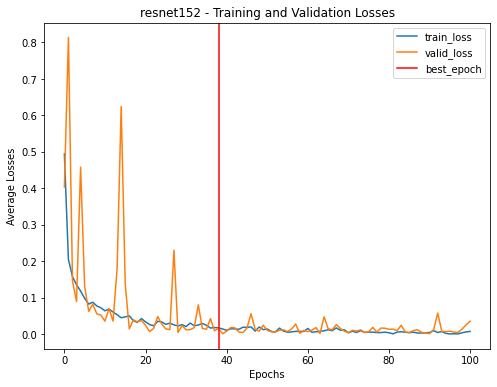

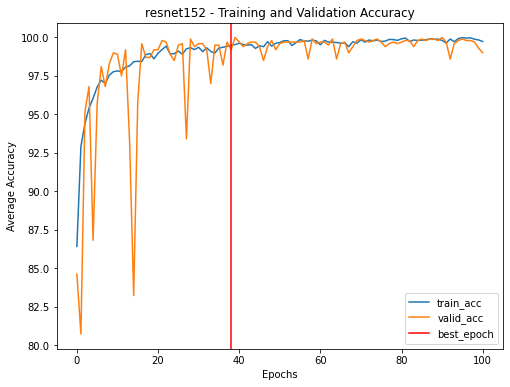

In [13]:
model_list = [
    models.alexnet.__name__, # 0
    models.squeezenet1_1.__name__, #1
    models.resnet50.__name__, # 2
    models.resnet101.__name__, # 3
    models.resnet152.__name__, # 4
    models.resnext101_32x8d.__name__, # 5
    models.densenet201.__name__, # 6
    models.googlenet.__name__, # 7
    models.vgg16.__name__, # 8
    models.vgg19.__name__, #9
    models.inception_v3.__name__, #10
    CovidnetModel.__name__, #11
]

for i in range(0, len(model_list)):
  # https://github.com/pytorch/pytorch/issues/50198
  # skipped these because cannot use deterministic algorithm
#   skip_model = [0, 1, 5, 8, 9, 10]
#   skip_model = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#   if i in skip_model:
#     continue
  if model_list[i] is not models.resnet152.__name__:
    continue
  curr_model = model_list[i]

  # Initialize model, criterion and optimizer
  model, criterion, optimizer, scaler = init_model(curr_model)

#   Training & Validation
  model, history, perf = train(
      model,
      criterion,
      optimizer,
      scaler,
      train_loader,
      val_loader,
      model_path=f'{path.join(RESULT_DIR, curr_model)}.pt',
      max_epochs_stop=5,  # Early stopping intialization
      n_epochs=100,
      min_epoch=100,
      print_every=10)

  history
  save_train_val_loss_graph(history, perf)
  save_train_val_acc_graph(history, perf)
  getConfusionMatrix(model, val_loader)

## Download Results
<a href="/kaggle/working/result/CovidnetModel - Training and Validation Accuracy.png"> CovidnetModel - Training and Validation Accuracy.png </a> </br>
<a href="/kaggle/working/result/CovidnetModel - Training and Validation Losses.png"> CovidnetModel - Training and Validation Losses.png </a> </br>
<a href="/kaggle/working/result/CovidnetModel.pt"> CovidnetModel.pt </a> </br>

In [16]:
%cd /kaggle/working/log
!ls
from IPython.display import FileLink
# FileLink(r'CovidnetModel - Training and Validation Accuracy.png')
# FileLink(r'CovidnetModel - Training and Validation Losses.png')
FileLink(r'googlenet.txt')

/kaggle/working/log
CovidnetModel.txt  googlenet.txt  resnet101.txt  resnext101_32x8d.txt
densenet201.txt    old		  resnet50.txt


/kaggle/working/log/googlenet.txt

------------------------------------------------------------------------

# Final Evaluation

------------------------------------------------------------------------
- After selecting the best hyperparameters and models, use the model to predict the result on the test images
    - Get the confusion matrix and prediction similar to what we did for validation images
- Run GradCam to visualize which regions in the image the model are activated

## Run Test

In [14]:
def reloadModel():
  saved_model_path = f'{path.join(RESULT_DIR, curr_model)}.pt'
  if os.path.exists(saved_model_path):
    model, criterion, optimizer, scaler = init_model(curr_model)
    return load_model(model, optimizer, scaler, saved_model_path)
  else:
    return None, None, None, None, None, None

model_list = [
    models.alexnet.__name__, # 0
    models.squeezenet1_1.__name__, #1
    models.resnet50.__name__, # 2
    models.resnet101.__name__, # 3
    models.resnet152.__name__, # 4
    models.resnext101_32x8d.__name__, # 5
    models.densenet201.__name__, # 6
    models.googlenet.__name__, # 7
    models.vgg16.__name__, # 8
    models.vgg19.__name__, #9
    models.inception_v3.__name__, #10
    CovidnetModel.__name__, #11
]

for i in range(0, len(model_list)):
#   skip_model = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]
#   if i in skip_model:
#     continue
  if model_list[i] is not models.resnet152.__name__:
    continue
  curr_model = model_list[i]
  _, model, _, _, _, _ = reloadModel()
  seed_everything()
  if model:
    trainable_parameters = count_parameters(model)
    print(f'model: {curr_model}, number of trainable parameters: {trainable_parameters}')

# getConfusionMatrix(model, test_loader, True)
# visualize_test_prediction(model)


env: PYTHONHASHSEED=18
resnet152 is initialized
env: PYTHONHASHSEED=18
model: resnet152, number of trainable parameters: 58149955


## Run GradCam
- This repo is used instead due to much better support with pytorch - https://github.com/frgfm/torch-cam
- [This reference](https://github.com/jacobgil/pytorch-grad-cam) is obselete as need to find the layer manually, and facing `IndexError: index 2 is out of bounds for dimension 1 with size 2`

env: PYTHONHASHSEED=18
resnet152 is initialized
occurrence= {0: 71488, 1: 42943, 2: 310593}
target_remove_count= {0: 69806, 1: 41932, 2: 303285}
env: PYTHONHASHSEED=18
tensor([[-14.9217,  -3.8074,  18.9974]], device='cuda:0')
env: PYTHONHASHSEED=18
img=tensor([[[[-0.4510, -0.6078, -0.6471,  ..., -0.6471, -0.6471, -0.6471],
          [-0.5451, -0.5608, -0.5451,  ..., -0.6078, -0.5843, -0.6157],
          [-0.6235, -0.5294, -0.4588,  ..., -0.5294, -0.5137, -0.5686],
          ...,
          [-0.3098, -0.4588, -0.5686,  ..., -0.4588, -0.5294, -0.4745],
          [-0.2157, -0.4431, -0.4196,  ..., -0.4196, -0.4510, -0.4510],
          [-0.1451, -0.3961, -0.2784,  ..., -0.3725, -0.3412, -0.3961]],

         [[-0.4510, -0.6078, -0.6471,  ..., -0.6471, -0.6471, -0.6471],
          [-0.5451, -0.5608, -0.5451,  ..., -0.6078, -0.5843, -0.6157],
          [-0.6235, -0.5294, -0.4588,  ..., -0.5294, -0.5137, -0.5686],
          ...,
          [-0.3098, -0.4588, -0.5686,  ..., -0.4588, -0.5294, -0.47

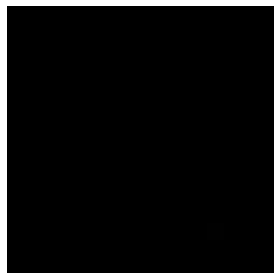

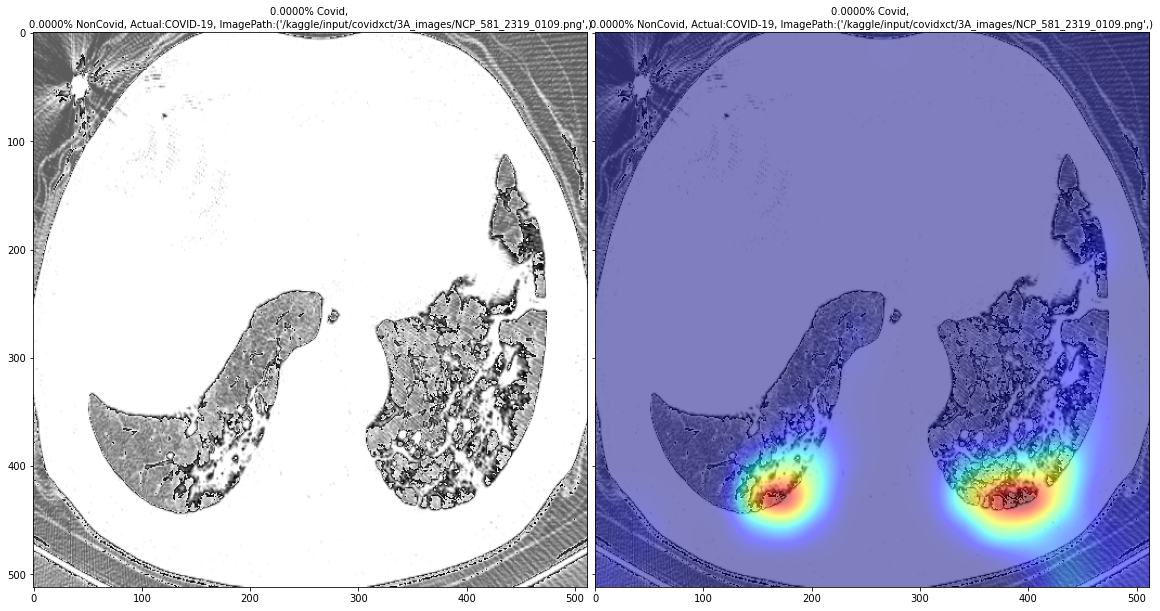

In [15]:
CURR_DIR = "/kaggle/working"
RESULT_DIR = os.path.join(CURR_DIR, 'result')

# !pip install git+https://github.com/frgfm/torch-cam.git#egg=torchcam
!pip install torchcam==0.3.0
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_tensor, to_pil_image
from torchcam.cams import SmoothGradCAMpp
# from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from PIL import ImageOps
from mpl_toolkits.axes_grid1 import ImageGrid
import math

""" 
Class activation explorer using TorchCAM.
Iterate through validation database and overlay images with class activation 
heatmap.

Reference: https://github.com/frgfm/torch-cam 
"""
def runGradCam():
    _, model, _, _, _, _ = reloadModel()

    if not model:
        return

#     torch.autograd.set_detect_anomaly(True)
    MAX_COUNT = 10000
    full_dataset_with_path = CovidNetDatasetWithPath(DATASET_DIR, SPLIT_FILES, MAX_COUNT)
    cam_loader = DataLoader(WrapperDatasetWith3Items(full_dataset_with_path, image_transforms['val']), batch_size=BATCH_SIZE, sampler=val_sampler)
    class_names, _ = full_dataset_with_path.find_classes()
    
    NUM_ITER = 1
    pred_probs = getPredProbsForGradCam(model, cam_loader, NUM_ITER)
    cam_extractor = SmoothGradCAMpp(model) # this steps already does model.eval()
    
    seed_everything()

    for i, (img, cls, ori_path) in enumerate(cam_loader):
        if i >= NUM_ITER:
            break

#         print(f"img={img}, img shape={img.shape}, cls={cls}, ori_path={ori_path}")
        if is_gpu_avail():
            img = img.cuda()
        # Preprocess your data and feed it to the model
#         out = model(img.unsqueeze(0))
        out = model(img)
#         print(f"runGradCam out={out}")
        # Retrieve the CAM by passing the class index and the model output
        cls_idx = cls.item()
        activation_map = cam_extractor(cls_idx, out)

        # Resize the CAM and overlay it
        # https://matplotlib.org/stable/tutorials/colors/colormaps.html#miscellaneous
        ori_img = to_pil_image(img.squeeze(0))
        activation_map = to_pil_image(activation_map[0], mode='F')
        plt.imshow(activation_map); plt.axis('off'); plt.tight_layout(); plt.show()
        
#         print(f"img shape={img.shape}, img type={img.dtype}, act_map type={activation_map.dtype}")
#         result = overlay_mask(ori_img, activation_map, colormap='jet', alpha=0.5)
        result = overlay_mask(ori_img, activation_map, alpha=0.5)

        # Display it
        # https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html
        fig = plt.figure(figsize=(20., 20.))
        grid = ImageGrid(fig, 111,    # similar to subplot(111)
                                        nrows_ncols=(1, 2),    # creates 1x2 grid of axes
                                        axes_pad=0.1,    # pad between axes in inch.
                                        )
        for ax, im in zip(grid, [ori_img, result]):
            # Iterating over the grid returns the Axes.
            cls_str = class_names[cls_idx]
            ax.set_title("{:.4f}% Covid, \n{:.4f}% NonCovid, Actual:{}, ImagePath:{}".format(100*pred_probs[i,0],
                100*pred_probs[i,1],
                cls_str, ori_path), fontsize=10)
            ax.imshow(im)
        title = f'{curr_model} - GradCam++ Visualization'
        full_path = os.path.join(RESULT_DIR, f'{title}.png')
        plt.savefig(full_path)
        plt.show()

BATCH_SIZE = 1
# curr_model = CovidnetModel.__name__
curr_model = models.resnet152.__name__
runGradCam()

In [16]:
# !pip install git+https://github.com/frgfm/torch-cam.git#egg=torchcam
!pip install torchcam
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_tensor, to_pil_image
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from PIL import ImageOps
from mpl_toolkits.axes_grid1 import ImageGrid
import math

MAX_COUNT = 10000
full_dataset_with_path = CovidNetDatasetWithPath(DATASET_DIR, SPLIT_FILES, MAX_COUNT)
# cam_loader = DataLoader(WrapperDataset(full_dataset_with_path, image_transforms['val']), batch_size=BATCH_SIZE, sampler=val_sampler)
# NUM_ITER = 2
print(next(iter(full_dataset_with_path)))
# pred_probs = getPredProbsForGradCam(model, cam_loader, NUM_ITER)

{0: 71488, 1: 42943, 2: 310593}
{0: 69806, 1: 41932, 2: 303285}
(<PIL.Image.Image image mode=L size=503x311 at 0x7F8EADAA9810>, 2, '/kaggle/input/covidxct/3A_images/NCP_96_1328_0032.png')


In [ ]:
print(next(iter(WrapperDatasetWith3Items(full_dataset_with_path, image_transforms['val']))))

------------------------------------------------------------------------

# Playground

------------------------------------------------------------------------

> Testbed that is not compulsary for any part of this notebook

## Visualizing Models using PytorchViz

-   https://pytorch.org/docs/stable/nn.html
-   https://discuss.pytorch.org/t/combining-multiple-models-and-datasets/82623
-   [Mandrin explanation of pytorch resnet
    code](https://www.jianshu.com/p/90d61f53d15d)

In [ ]:
import torch
from torch import nn
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace

In [ ]:
# from torchinfo import summary
%pip install -U torchsummary
from torchsummary import summary

if is_gpu_avail():
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device('cpu')


# model = models.googlenet()
# summary(model, (3, 299, 299))

# model = ResidualBlock(192, 192, BlockType.IDENTITY, 1)
# summary(model, (192, 28, 28))

# model = ResidualBlock(192, 256, BlockType.CONV, 1) # also works if 192,192
# summary(model, (192, 28, 28))

# model = ResidualBlock(256, 320, BlockType.CONV, 1) # also works if 192,192
# summary(model, (256, 28, 28))

# model = ReductionBlock(1024, 192)
# summary(model, (1024, 28, 28))

# residual_block_layout = {
#     BlockType.CONV:[
#         dict(in_chan=192, out_chan=256),
#         dict(in_chan=256, out_chan=512),
#         dict(in_chan=512, out_chan=1024),
#     ],
#     BlockType.IDENTITY:[dict(in_chan=1024, out_chan=1024)]
# }
# model = CovidNetBlock(residual_block_layout, 192) 
# summary(model, (192, 28, 28))

model = CovidnetModel()
summary(model, (3, 224, 224))

# model = models.resnext50_32x4d()
# summary(model, (3, 224, 224))

# x = torch.randn(1, 3, 224, 224).requires_grad_(True)
# y = model(x)
# dot = make_dot(y, params=dict(model.named_parameters()))

# dot.format = "png"
# dot.render(render_model_pic_file)
# files.download(f"{render_model_pic_file}.{dot.format}")

## Investigate Image in Dataset

In [ ]:
import subprocess

# Specify all the filepath of the dataset
DATA_DIR = "/kaggle/input/covidxct"
DATASET_DIR = path.join(DATA_DIR, "3A_images/")
DATASET_NAME = "COVIDx_CT-3A"
TEST_SPLIT_FILE = path.join(DATA_DIR, f"test_{DATASET_NAME}.txt")

# count number of images
# !ls -Uba1 /content/data/3A_images | grep -c png
ls = subprocess.Popen(("ls", "-Uba1", DATASET_DIR), stdout=subprocess.PIPE)
output = subprocess.check_output(("grep", "-c", "png"), stdin=ls.stdout)
print(f"number of images: {output.decode()}")

# list first 10 images
ls = subprocess.Popen(("ls", "-Uba1", DATASET_DIR), stdout=subprocess.PIPE)
output = subprocess.check_output(("head", "-10"), stdin=ls.stdout)
first_10_lines = output.decode()
# print(f"first 10 images in {DATASET_DIR}:\n{first_10_lines}")
img_list = first_10_lines.split('\n')
first_png = next(filter(lambda img: "png" in img, img_list), None)
print(f"first_png: {first_png}\n")

In [ ]:
# show the first test image, unbounded followed by bounded
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as torch_func_trans
from PIL import Image

# from https://github.com/haydengunraj/COVIDNet-CT/blob/d1c6be5202a78d5f8802e40ff6b5b9d57189c797/dataset.py#L108
def get_data_from_split_file(split_file):
    """Gets image filenames, classes and bboxes"""
    files, classes, bboxes = [], [], []
    with open(split_file, 'r') as f:
        for line in f.readlines():
            fname, cls, xmin, ymin, xmax, ymax = line.strip('\n').split()
            files.append(path.join(DATASET_DIR, fname))
            classes.append(int(cls))
            bboxes.append([int(xmin), int(ymin), int(xmax), int(ymax)])
    return files, classes, bboxes

def bbox_to_topLeftOrigin_size(xmin, ymin, xmax, ymax):
    top = ymax
    left = xmin
    height = ymax - ymin
    width = xmax - xmin
    return top, left, height, width

files, classes, bbox = get_data_from_split_file(TEST_SPLIT_FILE)
first_file_tuple = (files[0], classes[0], bbox[0])

print(f"first image: {first_file_tuple[0]}")
if 0:
    # this way of reading image is deprecated
    img = plt.imread(first_file_tuple[0])

    fig = plt.figure(figsize=(15,15))
    plt.title("unbounded")
    _ = plt.imshow(img)
    _ = plt.axis('off')

    torch_img = torch.from_numpy(img)
    print(f"torch_img size: {torch_img.size()}")
    pytorch_size = bbox_to_topLeftOrigin_size(*first_file_tuple[2])
    print(f"pytorch_size: {pytorch_size}")

    cropped_img = torch_func_trans.crop(torch_img, *pytorch_size)
    fig = plt.figure(figsize=(15,15))
    plt.title("bounded")
    _ = plt.imshow(cropped_img)
    _ = plt.axis('off')

# This is the recommended method for opening image
# https://pillow.readthedocs.io/en/stable/reference/Image.html#examples
with Image.open(first_file_tuple[0]) as im:
    print("\n")
    print("Unbounded image")
    IMG = im
    display(im)

    print("\n")
    print("Bounded image")
    display(im.crop(first_file_tuple[2]))

    # https://pillow.readthedocs.io/en/latest/reference/open_files.html#file-handling
    print("\n")
    print("Out of Scope Unbounded image")
    display(IMG)
    

## Investigate metadata.csv

In [ ]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

# Specify all the filepath of the dataset
DATA_DIR = "/kaggle/input/covidxct"
dirs = [entry.name for entry in os.scandir(DATA_DIR) if entry.is_dir()]
assert len(dirs) == 1 # expects to only have 1 folder that contains all the images

DATASET_DIR = path.join(DATA_DIR, dirs[0])
METADATA_CSV = path.join(DATA_DIR, "metadata.csv")

meta_df = pd.read_csv(METADATA_CSV)
print("First 5 rows in metadata.csv0")
print(meta_df.head(5))
print(f"classes: {sorted(meta_df['finding'].unique())}")

unverified = meta_df['verified finding'].eq('No').sum()
verified = meta_df['verified finding'].eq('Yes').sum()
print(f"Not verified: {unverified}")
print(f"Verified: {verified}")

unverified_patient_ids = meta_df.loc[meta_df['verified finding'] == 'No', 'patient id'].unique()
assert len(unverified_patient_ids) == unverified # patient id is expected to be unique in metadata.csv
print(f"first unverified ID: {unverified_patient_ids[0]}")

verified_patient_ids = meta_df.loc[meta_df['verified finding'] == 'Yes', 'patient id'].unique()
assert len(verified_patient_ids) == verified # patient id is expected to be unique in metadata.csv
print(f"first verified ID: {verified_patient_ids[0]}")

imgs = [entry.name for entry in os.scandir(DATASET_DIR) if entry.is_file()]
print(f"total images: {len(imgs)}")
print(f"first 10 images: {imgs[:10]}")
imgs_of_1_patient = [img for img in imgs if verified_patient_ids[0] in img]
print(f"Images of patient ID {verified_patient_ids[0]}: {imgs_of_1_patient}")

## Investigating split dataset

In [ ]:
# Specify all the filepath of the dataset
DATA_DIR = "/kaggle/input/covidxct"
dirs = [entry.name for entry in os.scandir(DATA_DIR) if entry.is_dir()]
assert len(dirs) == 1 # expects to only have 1 folder that contains all the images

DATASET_DIR = path.join(DATA_DIR, dirs[0])
METADATA_CSV = path.join(DATA_DIR, "metadata.csv")

DATASET_NAME = "COVIDx_CT-3A"
TRAIN_SPLIT_FILE = path.join(DATA_DIR, f"train_{DATASET_NAME}.txt")
VAL_SPLIT_FILE = path.join(DATA_DIR, f"val_{DATASET_NAME}.txt")
TEST_SPLIT_FILE = path.join(DATA_DIR, f"test_{DATASET_NAME}.txt")
SPLIT_FILES = [TRAIN_SPLIT_FILE, VAL_SPLIT_FILE, TEST_SPLIT_FILE]

full_dataset = CovidNetDataset(DATASET_DIR, SPLIT_FILES)
full_data_len = len(full_dataset)
print(f"Length of full dataset: {full_data_len}")

SEED = 18
seed_everything(SEED)
BATCH_SIZE = 64

# # Defines ratios, w.r.t. whole dataset.
ratio_train = 0.8
ratio_val = 0.1
ratio_test = 0.1
dummy_X = np.zeros(full_data_len)
indexes = np.arange(full_data_len)

# Produces test split. Uses train_test_split instead of StratifiedShuffleSplit to get x_remaining & y_remaining
# to be used in the next step. 
# Note that an additional indexes array is provided
x_remaining, X_test, y_remaining, Y_test, temp_train_index, test_index = train_test_split(
    dummy_X, full_dataset.targets, indexes, test_size=ratio_test, stratify=full_dataset.targets, random_state=SEED)
# train_index, test_index = next(
#     StratifiedShuffleSplit(n_splits=1, test_size=ratio_test, random_state=SEED).split(
#         dummy_X, full_dataset.targets
#     )
# )

print('*'*50)
print("temp_train")
print('*'*50)
print(f"First 10 index: {temp_train_index[:10]}")
print(f"First 10 label: {y_remaining[:10]}")
print(f"length of index: {len(temp_train_index)}")
print(">>>Distribution of labels:")
print(f"Normal: {y_remaining.count(0)}")
print(f"Pneunomia: {y_remaining.count(1)}")
print(f"Covid-19: {y_remaining.count(2)}")

print()
print('*'*50)
print("test")
print('*'*50)
print(f"First 10 index: {test_index[:10]}")
print(f"First 10 label: {Y_test[:10]}")
print(f"length of index: {len(test_index)}\n")
print(">>>Distribution of labels:")
print(f"Normal: {Y_test.count(0)}")
print(f"Pneunomia: {Y_test.count(1)}")
print(f"Covid-19: {Y_test.count(2)}")

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
X_train, X_val, Y_train, Y_val, train_index, val_index = train_test_split(
    x_remaining, y_remaining, temp_train_index, test_size=ratio_val_adjusted, stratify=y_remaining, random_state=SEED)

print()
print('*'*50)
print("train")
print('*'*50)
print(f"First 10 index: {train_index[:10]}")
print(f"First 10 label: {Y_train[:10]}")
print(f"length of index: {len(train_index)}\n")
print(">>>Distribution of labels:")
print(f"Normal: {Y_train.count(0)}")
print(f"Pneunomia: {Y_train.count(1)}")
print(f"Covid-19: {Y_train.count(2)}")

print()
print('*'*50)
print("val")
print('*'*50)
print(f"First 10 index: {val_index[:10]}")
print(f"First 10 label: {Y_val[:10]}")
print(f"length of index: {len(val_index)}\n")
print(">>>Distribution of labels:")
print(f"Normal: {Y_val.count(0)}")
print(f"Pneunomia: {Y_val.count(1)}")
print(f"Covid-19: {Y_val.count(2)}")

## Visualizing Dataloader

In [ ]:
import pprint
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    plt.figure(figsize=[15, 15])
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

seed_everything(19)
class_names, _ = full_dataset.find_classes()
data, classes = next(iter(train_loader)) # note that it is normal for warning about clipping here if the image has been normalized
# out = torchvision.utils.make_grid(data)
# imshow(out)
# pp = pprint.PrettyPrinter(compact=True)
# pp.pprint([class_names[x] for x in classes])

print(f"Class: {classes[0]}")
out = data[0]
imshow(out)

## Trying Avalance

In [ ]:
# https://changhsinlee.com/colab-import-python/
!pip install requests
!pip install avalanche-lib

In [ ]:
import requests

# Save datagenerators as file to colab working directory
# If you are using GitHub, make sure you get the "Raw" version of the code
url = 'https://raw.githubusercontent.com/ContinualAI/avalanche/master/examples/pytorchcv_models.py'
r = requests.get(url)

# make sure your filename is the same as how you want to import 
with open('pytorchcv_models.py', 'w') as f:
    f.write(r.text)

# now we can import
import pytorchcv_models as pycv
from types import SimpleNamespace

args = SimpleNamespace()
args.cuda = 0
pycv.main(args)

## Pretrained Model

### Helper Functions

In [ ]:
LOG_DIR = os.path.join(CURR_DIR, "log")
RESULT_DIR = os.path.join(CURR_DIR, 'result')
curr_model = ""

def log_to_file(txt=None, print_to_console_only=False):
  if txt is None:
    txt = ''
  txt += '\n'
  print(txt)
  if print_to_console_only:
    return
  if not path.exists(LOG_DIR):
    os.mkdir(LOG_DIR)
  full_path = os.path.join(LOG_DIR, f'{curr_model}.txt')
  with open(full_path, mode='a') as f:
    f.write(txt)
    
# https://discuss.pytorch.org/t/clearing-the-gpu-is-a-headache/84762
# Make sure to delete any references to tensor. Else this function will not have significant effect
def clean_vram():
    gc.collect()
    torch.cuda.empty_cache()
    
# https://stackoverflow.com/questions/33162319/get-current-function-name-inside-that-function-using-python
def name_of_caller(frame=1):
    """
    Return "class.function_name" of the caller or just "function_name".
    """
    frame = sys._getframe(frame)
    fn_name = frame.f_code.co_name
    var_names = frame.f_code.co_varnames
    if var_names:
        if var_names[0] == "self":
            self_obj = frame.f_locals.get("self")
            if self_obj is not None:
                return f"{type(self_obj).__name__}.{fn_name}" 
        if var_names[0] == "cls":
            cls_obj = frame.f_locals.get("cls")
            if cls_obj is not None:
                return f"{cls_obj.__name__}.{fn_name}"
    return fn_name

### Define Function to Initialize Deep Learning Models

In [ ]:
model_constructors = {
  models.alexnet.__name__: models.alexnet, 
  models.squeezenet1_1.__name__: models.squeezenet1_1,
  models.resnet50.__name__: models.resnet50, 
  models.resnet101.__name__: models.resnet101,
  models.resnet152.__name__: models.resnet152, 
  models.resnext101_32x8d.__name__: models.resnext101_32x8d, 
  models.densenet201.__name__: models.densenet201, 
  models.googlenet.__name__: models.googlenet, 
  models.vgg16.__name__: models.vgg16, 
  models.vgg19.__name__: models.vgg19, 
  models.inception_v3.__name__: models.inception_v3, 
}

from torchvision.models import *
model_weights = {
  models.alexnet.__name__: AlexNet_Weights.DEFAULT,
  models.squeezenet1_1.__name__: SqueezeNet1_1_Weights.DEFAULT,
  models.resnet50.__name__: ResNet50_Weights.DEFAULT,
  models.resnet101.__name__: ResNet101_Weights.DEFAULT,
  models.resnet152.__name__: ResNet152_Weights.DEFAULT,
  models.resnext101_32x8d.__name__: ResNeXt101_32X8D_Weights.DEFAULT,
  models.densenet201.__name__: DenseNet201_Weights.DEFAULT,
  models.googlenet.__name__: GoogLeNet_Weights.DEFAULT,
  models.vgg16.__name__: VGG16_Weights.DEFAULT,
  models.vgg19.__name__: VGG19_Weights.DEFAULT,
  models.inception_v3.__name__: Inception_V3_Weights.DEFAULT,
}

# Experiment around dropout & Learning Rate & different optimizer (Adam)
def init_model(name):
  if not path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)

  clean_vram()
  seed_everything()
  model = model_constructors[name](weights=model_weights[name])
  
  # fine-tune pretrain models to our usecase
  # https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#initialize-and-reshape-the-networks
  NUM_CLASSES = len(class_names)
  DROPOUT = 0.5
  if name == models.alexnet.__name__ or name == models.vgg16.__name__ or name == models.vgg19.__name__:
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, NUM_CLASSES)
#     model.classifier[6] = nn.Sequential(
#       nn.Dropout(DROPOUT),
#       nn.Linear(num_ftrs, NUM_CLASSES)
#     )
  elif name == models.densenet201.__name__:
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, NUM_CLASSES)
#     model.classifier = nn.Sequential(
#       nn.Dropout(DROPOUT),
#       nn.Linear(num_ftrs, NUM_CLASSES)
#     )
  elif name == models.squeezenet1_1.__name__:
    model.classifier = nn.Conv2d(512, NUM_CLASSES, kernel_size=(1,1), stride=(1,1))
#     model.classifier = nn.Sequential(
#       nn.Dropout(DROPOUT),
#       nn.Conv2d(512, NUM_CLASSES, kernel_size=(1,1), stride=(1,1))
#     )
    model.num_classes = NUM_CLASSES
  elif name == models.inception_v3.__name__:
    auxLogits_num_ftrs = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Linear(auxLogits_num_ftrs, NUM_CLASSES)
#     model.AuxLogits.fc = nn.Sequential(
#       nn.Dropout(DROPOUT),
#       nn.Linear(auxLogits_num_ftrs, NUM_CLASSES)
#     )
    primary_num_ftrs = model.fc.in_features
    model.fc = nn.Linear(primary_num_ftrs, NUM_CLASSES)
#     model.fc = nn.Sequential(
#       nn.Dropout(DROPOUT),
#       nn.Linear(primary_num_ftrs, NUM_CLASSES)
#     )
  else:
    # resnet, resnext & googlenet
    num_ftrs = model.fc.in_features
    model.fc= nn.Linear(num_ftrs, NUM_CLASSES)
#     model.fc = nn.Sequential(
#       nn.Dropout(DROPOUT),
#       nn.Linear(num_ftrs, NUM_CLASSES)
#     )

  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer= optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  if is_gpu_avail():
    # Use Automatic Mixed Precision as an attempt to solve CUDA out of memory and to speed things up
    # https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html#all-together-automatic-mixed-precision
    scaler = torch.cuda.amp.GradScaler()
  else:
    raise RuntimeError('This code only support machine with GPU.')

  # print('=====================================')
  print(f'{name} is initialized')
  # print('=====================================')
  # print(model)
  return model, criterion, optimizer, scaler

# https://pytorch.org/tutorials/beginner/saving_loading_models.html
# https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html
def save_model(perf_metrics, model, optimizer, scaler, history, model_path):
  torch.save({
    'perf_metrics': perf_metrics,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    "scaler_state_dict": scaler.state_dict(),
    'history': history,
    }, model_path)

def load_model(model, optimizer, scaler, model_path):
  if not os.path.exists(model_path):
    log_to_file(f">>> WARN: {name_of_caller()}() model path '{model_path}' don't exist!")
    return None, model, optimizer, scaler, None, None
  checkpoint = torch.load(model_path)
  perf_metrics = checkpoint['perf_metrics']
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  scaler.load_state_dict(checkpoint['scaler_state_dict'])
  history = checkpoint['history']
  total_epoch = len(history) - 1
  del checkpoint

  return perf_metrics, model, optimizer, scaler, history, total_epoch

### Define Function to Train Models

In [ ]:
# training and validation loops
def train(model,
    criterion,
    optimizer,
    scaler,
    train_dataloader,
    valid_dataloader,
    model_path,
    max_epochs_stop=10,
    n_epochs=400,
    min_epoch=300,
    print_every=1):
    
    epochs_no_improve = 0
    perf = {
        'best_epoch': 0,
        'valid_loss_min': np.Inf,
        'valid_best_acc': 0,
    }
    total_epoch = 0

    try:
        if os.path.exists(model_path):
            perf, model, optimizer, scaler, history, total_epoch = load_model(model, optimizer, scaler, model_path)
            log_to_file(f'Model has been trained for: {total_epoch} epochs.')
            log_to_file(f"Best epoch: {perf['best_epoch']} with loss: {perf['valid_loss_min']:.4f} and acc: {100 * perf['valid_best_acc']:.2f}%\n")
        else:
            history = []
            log_to_file(f'Starting Training from Scratch.\n')
    except:
        history = []
        log_to_file(f'exception: start from scratch.\n')

    overall_start = time.time()
    if total_epoch >= n_epochs:
        log_to_file(f'Model has been fully trained. n_epochs specified is: {n_epochs} epochs.')
        history = pd.DataFrame(
            history,
            columns=['train_loss', 'valid_loss','train_acc', 'valid_acc'])
        return model, history, perf

    seed_everything()

    # Main loop - continue training on where we left off if there's a saved model
    for epoch in range(total_epoch, n_epochs):
        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = time.time()
        for ii, (data, target) in enumerate (train_dataloader):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()

            # only for inception_v3 - https://discuss.pytorch.org/t/why-auxiliary-logits-set-to-false-in-train-mode/40705/15
            with torch.cuda.amp.autocast():
              # output, aux_output = model(data)
              # loss1 = criterion(output, target)
              # loss2 = criterion(aux_output, target)
              # loss = loss1 + 0.4*loss2
              output = model(data)
              loss = criterion(output, target)
            # loss.backward()
            # optimizer.step()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * data.size(0)
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_dataloader):.2f}% complete. {time.time() - start:.2f} seconds elapsed in epoch.', end="\r")
            
            # cleanup to save VRAM
            del data, target
#             clean_vram()

        # After training loops ends, start validation
        else:
            print(">>> Starting validation...\n")
            with torch.no_grad():
                model.eval()
                for data, target in valid_dataloader:
                    if is_gpu_avail():
                        data, target = data.cuda(), target.cuda()
                    output = model(data)
                    loss = criterion(output, target)
                    valid_loss += loss.item() * data.size(0)
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    valid_acc += accuracy.item() * data.size(0)
                    
                    # cleanup to save VRAM
                    del data, target
#                     clean_vram()
                train_loss = train_loss / train_data_size
                valid_loss = valid_loss / valid_data_size
                train_acc = train_acc / train_data_size
                valid_acc = valid_acc / valid_data_size
                history.append([train_loss, valid_loss,train_acc, valid_acc])
                if (epoch + 1) % print_every == 0:
                    log_to_file(f'Epoch: {epoch}', True)
                    log_to_file(
                        f'Training Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}',
                        True
                    )
                    log_to_file(
                        f'Training Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}% \n',
                        True
                    )
          
                if valid_loss < perf['valid_loss_min']:
                    print(f">>> Saving model: valid_loss:{valid_loss}\n")
                    epochs_no_improve = 0
                    perf['best_epoch'] = epoch
                    perf['valid_loss_min'] = valid_loss
                    perf['valid_best_acc'] = valid_acc
                    save_model(perf, model, optimizer, scaler, history, model_path)
                else:
                    print(f">>> No improvement: valid_loss:{valid_loss}; epoch:{epoch}; epochs_no_improve:{epochs_no_improve}\n")
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epoch > min_epoch and epochs_no_improve >= max_epochs_stop:
                        log_to_file(
                            f"\nEarly Stopping! Total epochs: {epoch}. Best epoch: {perf['best_epoch']} with loss: {perf['valid_loss_min']:.4f} and acc: {100 * perf['valid_best_acc']:.2f}%"
                        )
                        total_time = time.time() - overall_start
                        log_to_file(
                            f'{total_time:.4f} total seconds elapsed. {total_time / (epoch+1):.4f} seconds per epoch.'
                        )
                        log_to_file()

                        # Load the best state from saved model
                        _, model, optimizer, scaler, _, _ = load_model(model, optimizer, scaler, model_path)
                        # save the full history
                        save_model(perf, model, optimizer, scaler, history, model_path)

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history, perf
    
    total_time = time.time() - overall_start
    log_to_file(
        f"\nBest epoch: {perf['best_epoch']} with loss: {perf['valid_loss_min']:.4f} and acc: {100 * perf['valid_best_acc']:.4f}%"
    )
    log_to_file(
        f"{total_time:.4f} total seconds elapsed. {total_time / (perf['best_epoch']+1):.4f} seconds per epoch."
    )
    log_to_file()

    # Load the best state from saved model
    _, model, optimizer, scaler, _, _ = load_model(model, optimizer, scaler, model_path)
    # save the full history
    save_model(perf, model, optimizer, scaler, history, model_path)

    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss','train_acc', 'valid_acc'])
    
    return model, history, perf


def save_train_val_loss_graph(history, perf):
  plt.figure(figsize=(8, 6))
  for c in ['train_loss', 'valid_loss']:
      plt.plot(
          history[c], label=c)

  title = f'{curr_model} - Training and Validation Losses'
  full_path = os.path.join(RESULT_DIR, f'{title}.png')
  plt.xlabel('Epochs')
  plt.ylabel('Average Losses')
  plt.title(title)
  plt.axvline(x=perf['best_epoch'], color='r', label='best_epoch')
  plt.legend()
  plt.savefig(full_path, bbox_inches='tight')


def save_train_val_acc_graph(history, perf):
  plt.figure(figsize=(8, 6))
  for c in ['train_acc', 'valid_acc']:
      plt.plot(
          100 * history[c], label=c)
      
  title = f'{curr_model} - Training and Validation Accuracy'
  full_path = os.path.join(RESULT_DIR, f'{title}.png')
  plt.xlabel('Epochs')
  plt.ylabel('Average Accuracy')
  plt.title(title)
  plt.axvline(x=perf['best_epoch'], color='r', label='best_epoch')
  plt.legend()
  plt.savefig(full_path, bbox_inches='tight')

### Define Functions to Visualize Prediction

In [ ]:
# confusion matrix 
def getConfusionMatrix(model, dataloader, is_test=False, show_image=False, print_to_console_only=False):
    model.eval()
    confusion_matrix=np.zeros((2,2),dtype=int)
    num_images=test_data_size
    
    with torch.no_grad():
        for i, (data,target) in enumerate(dataloader):
            data = data.to(device)
            target = target.to(device)
            
            output = model(data) 
            _, pred = torch.max(output, 1)
            
            for j in range(data.size()[0]): 
                if pred[j]==1 and target[j]==1:
                    term='TP'
                    confusion_matrix[0][0]+=1
                elif pred[j]==1 and target[j]==0:
                    term='FP'
                    confusion_matrix[1][0]+=1
                elif pred[j]==0 and target[j]==1:
                    term='FN'
                    confusion_matrix[0][1]+=1
                elif pred[j]==0 and target[j]==0:
                    term='TN'
                    confusion_matrix[1][1]+=1
            
                if show_image:
                    log_to_file(f'predicted: {class_names[pred[j]]}', print_to_console_only)
                    log_to_file(term, print_to_console_only)
                    imshow(data.cpu().data[j])
        
        log_to_file(None, print_to_console_only)
        category = 'Test' if is_test else 'Validation'
        log_to_file('=====================', print_to_console_only)
        log_to_file(f'{category} Results ', print_to_console_only)
        log_to_file('=====================', print_to_console_only)
        log_to_file('Confusion Matrix: ', print_to_console_only)
        log_to_file(np.array2string(confusion_matrix), print_to_console_only)
        log_to_file(None, print_to_console_only)

        log_to_file(f'Sensitivity: {100*confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1])}', print_to_console_only)
        log_to_file(f'Specificity: {100*confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0])}', print_to_console_only)
        log_to_file(f'PPV: {100*confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[1][0])}', print_to_console_only)
        log_to_file(f'NPV: {100*confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[0][1])}', print_to_console_only)
        log_to_file(f'Accuracy: {100*(confusion_matrix[0][0]+confusion_matrix[1][1])/(confusion_matrix[0][0]+confusion_matrix[0][1]+confusion_matrix[1][1]+confusion_matrix[1][0])}', print_to_console_only)
        log_to_file(f'F1-Score: {(2*confusion_matrix[0][0])/(2*confusion_matrix[0][0]+confusion_matrix[1][0]+confusion_matrix[0][1])}', print_to_console_only)
        log_to_file(None, print_to_console_only)
    return confusion_matrix


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def save_test_acc_n_loss_graph(model, dataloader, criterion):
  pass
  # NOT NEEDED YET
  # with torch.no_grad():
  #   model.eval()
  #   for data, target in dataloader:
  #       if is_gpu_avail():
  #           data, target = data.cuda(), target.cuda()
  #       output = model(data)
  #       loss = criterion(output, target)
  #       test_loss += loss.item() * data.size(0)
  #       _, pred = torch.max(output, dim=1)
  #       correct_tensor = pred.eq(target.data.view_as(pred))
  #       accuracy = torch.mean(
  #           correct_tensor.type(torch.FloatTensor))
  #       test_acc += accuracy.item() * data.size(0)
  #   train_loss = train_loss / train_data_size
  #   test_loss = test_loss / test_data_size
  #   train_acc = train_acc / train_data_size
  #   test_acc = test_acc / test_data_size


# def visualize_test_prediction(model):
#   covid_test_img_dir = '/content/drive/My Drive/data/test/covid/'
#   img_list = [Image.open(os.path.join(pth, f)).convert('RGB')
#       for pth, dirs, files in os.walk(covid_test_img_dir) for f in files]

#   # test_img_paths = ['/content/drive/My Drive/data/test/covid/2020.02.22.20024927-p19-68%3.png',
#   #                         '/content/drive/My Drive/data/test/covid/2020.02.22.20024927-p19-68%4.png',
#   #                         '/content/drive/My Drive/data/test/covid/2020.02.22.20024927-p19-68%5.png']
#   # img_list = [Image.open( img_path) for img_path in test_img_paths]

#   # log_to_file(img_list)

#   test_batch = torch.stack([image_transforms['test'](img).to(device)
#                               for img in img_list])
#   pred_logits_tensor = model(test_batch)
#   pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

#   row = 12
#   col = 3
#   fig, axs = plt.subplots(row, col, figsize=(20, 50))
#   r = 0
#   c = 0
#   for i, img in enumerate(img_list):
#       if c >= col:
#         r += 1
#         c = 0
#       ax = axs[r, c]
#       ax.axis('off')
#       ax.set_title("{:.4f}% Covid, {:.4f}% NonCovid".format(100*pred_probs[i,0],
#                                                               100*pred_probs[i,1]))
#       ax.imshow(img)
#       c +=1

#   title = f'{curr_model} - Covid Image Prediction'
#   full_path = os.path.join(RESULT_DIR, f'{title}.png')
#   plt.savefig(full_path, bbox_inches='tight')


def getPredProbs(model, datasetStr, count, isSeeded=True):
  if isSeeded:
    seed_everything()
  
  dataset = data[datasetStr].samples
  img_list = []
  for i, (img_path, cls_idx) in enumerate(dataset):
    if i >= count:
      break
    img_list.append(Image.open(img_path).convert('RGB'))

  test_batch = torch.stack([image_transforms[datasetStr](img).to(device)
                              for img in img_list])
  pred_logits_tensor = model(test_batch)
  return F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

### Run all models - Init Models + Training

In [ ]:
model_list = [
    models.alexnet.__name__, # 0
    models.squeezenet1_1.__name__, #1
    models.resnet50.__name__, # 2
    models.resnet101.__name__, # 3
    models.resnet152.__name__, # 4
    models.resnext101_32x8d.__name__, # 5
    models.densenet201.__name__, # 6
    models.googlenet.__name__, # 7
    models.vgg16.__name__, # 8
    models.vgg19.__name__, #9
    models.inception_v3.__name__, #10
]

for i in range(0,11):
  # https://github.com/pytorch/pytorch/issues/50198
  # skipped these because cannot use deterministic algorithm
#   skip_model = [0, 1, 5, 8, 9, 10]
  skip_model = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10]
  if i in skip_model:
    continue
  curr_model = model_list[i]

  # Initialize model, criterion and optimizer
  model, criterion, optimizer, scaler = init_model(curr_model)

#   Training & Validation
  model, history, perf = train(
      model,
      criterion,
      optimizer,
      scaler,
      train_loader,
      val_loader,
      model_path=f'{path.join(RESULT_DIR, curr_model)}.pt',
      max_epochs_stop=5,  # Early stopping intialization
      n_epochs=5,
      min_epoch=5,
      print_every=10)

  save_train_val_loss_graph(history, perf)
  save_train_val_acc_graph(history, perf)
  getConfusionMatrix(model, val_loader)

## Out of memory issue

- References
    - https://discuss.pytorch.org/t/using-main-ram-instead-of-vram/59344/3 
    - https://duckduckgo.com/?q=pytorch+colab+use+system+ram+instead+of+gpu+ram&ia=web
    - https://stackoverflow.com/questions/59129812/how-to-avoid-cuda-out-of-memory-in-pytorch
        - [CUDA Out of Memory discussion in kaggle forum](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/91081)
    - https://pytorch.org/docs/stable/notes/cuda.html#memory-management
    - [trick to debug tensor memory](https://forum.pyro.ai/t/a-trick-to-debug-tensor-memory/556)
- The fix
    - Delete unused tensor, force garbage collection and run `empty_cache()`
    - Set PYTORCH_CUDA_ALLOC_CONF to `max_split_size_mb:512`. This prevents the allocator to split block large than 512MB
    - [mixed precision training & delete checkpoint](https://medium.com/deep-learning-for-protein-design/a-comprehensive-guide-to-memory-usage-in-pytorch-b9b7c78031d3)

In [ ]:
torch.cuda.memory_stats(device)
# print(torch.cuda.memory_summary(device))